In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import IBMQ
from qiskit import Aer
from qiskit import execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, complete_meas_cal
from qiskit.visualization import plot_histogram

In [29]:
IBMQ.load_account()

In [3]:
# use this function to plot measurement results
# alternatively, use plot_histogram
def visualize_counts(counts_dict, plt=plt):
    """
    take a dictionary of measurement results and
    plot it as a bar chart
    """
    N_bits = len(list(counts_dict.keys())[0])
    N_values = 2**N_bits
    
    values = [ i for i in range(N_values) ]
    labels = [ bin(i)[2:].zfill(N_bits) for i in range(N_values)]
    counts = [ counts_dict.get(label,0) for label in labels ]
    
    plt.bar(values, counts/np.sum(counts), tick_label=labels)
    plt.xlabel("measurement outcome")
    plt.ylabel("probability")
    return plt


# use this function to display state tomography results
# alternatively, use plot_state_city
def visualize_two_qubit_tomography(tomo_data, clim_real=None, clim_imag=None):
    # safety check
    if np.shape(tomo_data) != (4,4):
        print ("The input must be a numpy array of shape (4,4).")
        return 
    
    # adjust plot ranges automatically
    if clim_real is None:
        clim_real = np.max(np.abs(np.real(tomo_data)))
    if clim_imag is None:
        clim_imag = np.max(np.abs(np.imag(tomo_data)))
    
    # plot real and imaginary part
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(np.real(tomo_data), cmap='RdBu')
    plt.clim(-clim_real,clim_real)
    plt.title("real part")
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(np.imag(tomo_data), cmap='RdBu')
    plt.clim(-clim_imag,clim_imag)
    plt.title("imaginary part")
    plt.colorbar()
    

# convert a state vector to a density matrix
def statevector_to_density_matrix(vec):
    return np.transpose(np.conjugate(np.array([vec]))) * np.array([vec])

In [4]:
# define a quantum register, called 'q' with 2 qubits
# and a classical register, called 'c' with 1 bit
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(2, 'c')

# Exercise 1

In the demonstration, we only generated the Bell state $\beta_{00}$. Now, we want to generalize this to generate all four possible Bell states.

Write a function **prepare_Bell_state(x, qr, cr)** which takes as an input
* an integer number x between 0 and 4
* a two-qubit quantum register qr
* a two-bit classical register cr

and outputs a quantum circuit that generates the Bell state $\beta_{ij}$ where $ij$ denotes the binary encoding of $x$.

In other words, the output for **prepare_Bell_state(0,qr,cr)** should be
```text
      ░ ┌───┐     
q_0: ─░─┤ H ├──■──
      ░ └───┘┌─┴─┐
q_1: ─░──────┤ X ├
      ░      └───┘
c: 2/═════════════
```
the output for **prepare_Bell_state(1,qr,cr)** should be
```text
     ┌───┐ ░ ┌───┐     
q_0: ┤ X ├─░─┤ H ├──■──
     └───┘ ░ └───┘┌─┴─┐
q_1: ──────░──────┤ X ├
           ░      └───┘
c: 2/══════════════════
```
the output for **prepare_Bell_state(2,qr,cr)** should be
```text
           ░ ┌───┐     
q_0: ──────░─┤ H ├──■──
     ┌───┐ ░ └───┘┌─┴─┐
q_1: ┤ X ├─░──────┤ X ├
     └───┘ ░      └───┘
c: 2/══════════════════
```
and the output for **prepare_Bell_state(3,qr,cr)** should be
```text
     ┌───┐ ░ ┌───┐     
q_0: ┤ X ├─░─┤ H ├──■──
     ├───┤ ░ └───┘┌─┴─┐
q_1: ┤ X ├─░──────┤ X ├
     └───┘ ░      └───┘
c: 2/══════════════════
```
Hint: ░ is a barrier. 

In [7]:
def encode_classical_information(x, qc, qubit0, qubit1):
    """
    append gates to the quantum circuit qc (assumed to be
    in the state |0...0>) such that the integer number x 
    in {0,1,2,3} is encoded into the quantum state
    """
    if x%4 == 1:
        qc.x(qubit0)
    elif x%4 == 2:
        qc.x(qubit1)
    elif x%4 == 3:
        qc.x(qubit0)
        qc.x(qubit1)
    
    return qc

In [8]:
def generate_Bell_state(qc, qubit0, qubit1):
    """
    append gates to the quantum circuit qc
    to generate a Bell state
    """
    qc.h(qubit0)
    qc.cnot(qubit0, qubit1)
    
    return qc

In [9]:
def prepare_Bell_state(x, qr, cr):
    qc = QuantumCircuit(qr, cr)
    qc = encode_classical_information(x, qc, qr[0], qr[1])
    qc.barrier()
    qc = generate_Bell_state(qc, qr[0], qr[1])
    
    return qc

In [12]:
# generate and visualize your quantum circuit:
qc = prepare_Bell_state(3, qr, cr)
qc.draw()

┌───┐ ░ ┌───┐     
q_0: ┤ X ├─░─┤ H ├──■──
     ├───┤ ░ └───┘┌─┴─┐
q_1: ┤ X ├─░──────┤ X ├
     └───┘ ░      └───┘
c: 2/══════════════════

<hr>

# Exercise 2

In exercise 1, we constructed four different quantum circuits to generate the four Bell states. Perform a statevector simulation to calculate the final state vector of these four circuits. Convince yourself that these circuits are generating Bell states.

Note: You can calculate all state vectors in parallel if you group the corresponding circuits into a list.

In [13]:
# create a list of all circuits
qcs = [ prepare_Bell_state(x, qr, cr) for x in range(4) ]

In [14]:
# do a statevector simultion of these circuits
sim_statevector = execute(qcs, Aer.get_backend('statevector_simulator'))

In [15]:
# read out the state vectors
results_statevector = sim_statevector.result()

In [17]:
# display the results
for i in range(len(qcs)):
    print (np.around(results_statevector.get_statevector(i),3))

[0.707+0.j 0.   +0.j 0.   +0.j 0.707+0.j]
[ 0.707-0.j  0.   +0.j  0.   +0.j -0.707+0.j]
[0.   +0.j 0.707+0.j 0.707+0.j 0.   +0.j]
[ 0.   +0.j -0.707+0.j  0.707-0.j  0.   +0.j]


<hr>

# Exercise 3a

Having checked that the four circuits generate Bell states, we now want to simulate their execution on a quantum computer. 

However, the only output a quantum computer can give to us are measurement results.
Therefore, take the four circuits and append measurement operations that determine the state of the qubits in the quantum register in the z basis. 

Do a QASM simulation of these circuits assuming an **ideal** quantum computer.
Visualize the measurement results and interpret them.

Hint: You can use the function visualize_counts() defined above to plot the result.

In [18]:
def measure_Bell_state(x, qr, cr):
    qc = prepare_Bell_state(x,qr,cr)
    qc.barrier()
    qc.measure(qr[0],cr[0])
    qc.measure(qr[1],cr[1])
    
    return qc

In [21]:
measure_Bell_state(3, qr, cr).draw()

┌───┐ ░ ┌───┐      ░ ┌─┐   
q_0: ┤ X ├─░─┤ H ├──■───░─┤M├───
     ├───┤ ░ └───┘┌─┴─┐ ░ └╥┘┌─┐
q_1: ┤ X ├─░──────┤ X ├─░──╫─┤M├
     └───┘ ░      └───┘ ░  ║ └╥┘
c: 2/══════════════════════╩══╩═
                           0  1

In [22]:
qcs = [ measure_Bell_state(x, qr, cr) for x in range(4) ]

In [23]:
# simulate the circuit on an ideal quantum computer
sim_qasm_ideal = execute(qcs, Aer.get_backend('qasm_simulator'), shots=8192)
results_qasm_ideal = sim_qasm_ideal.result()

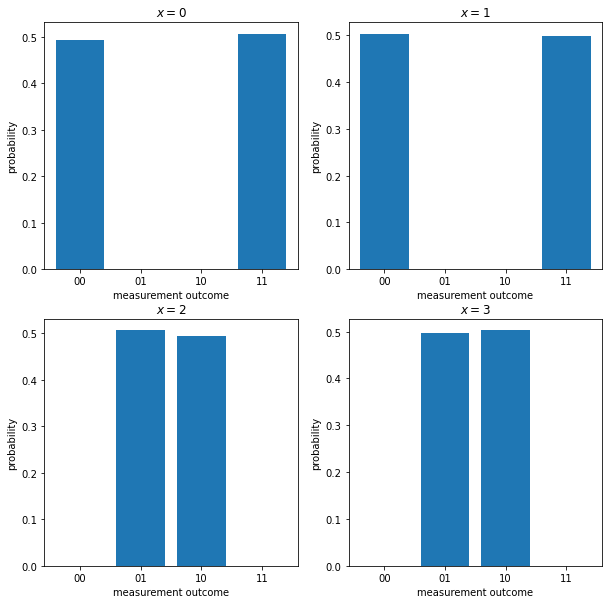

In [24]:
plt.figure(figsize=(10,10))
for x in range(len(qcs)):
    plt.subplot(2,2,x+1)
    plt = visualize_counts(results_qasm_ideal.get_counts(x), plt)
    plt.title("$x={}$".format(x))
plt.show()

# Exercise 3b

Repeat the same steps assuming a **realistic noise model** taken from an existing quantum computer of your choice. 

In [25]:
# select a real quantum computer and read out its (current!) noise properties
backend = IBMQ.get_provider('ibm-q').get_backend('ibmqx2')
noise_model = NoiseModel.from_backend(backend)

In [27]:
# simulate the same circuit taking into account noise
sim_qasm_real = execute(qcs, Aer.get_backend('qasm_simulator'), shots=8192, 
                        backend_properties=backend.properties(),
                        noise_model=noise_model)
results_qasm_real = sim_qasm_real.result()

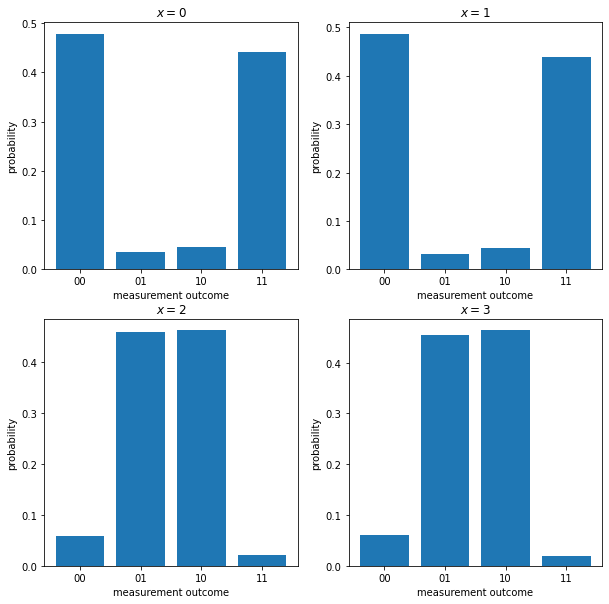

In [28]:
plt.figure(figsize=(10,10))
for x in range(len(qcs)):
    plt.subplot(2,2,x+1)
    plt = visualize_counts(results_qasm_real.get_counts(x), plt)
    plt.title("$x={}$".format(x))
plt.show()

<hr>

# Exercise 4

We would like to understand better the imperfections of a realistic quantum computer. 

To analyze the impact of different quantum gates on the errors, we want to add more gates to the quantum circuit without changing its output on an **ideal** quantum computer. A way to approach this task is to use that the Hadamard gate $H$ and the CNOT gate are their own inverses, i.e.,
$$ H \cdot H \cdot H = H $$
and
$$ CNOT \cdot CNOT \cdot CNOT = CNOT $$
That is, we can replace a single $H$ gate by an odd number of $H$ gates without (in theory) changing the output of the circuit. 
The same is true for CNOT gates. 
Of course, the output on a **noisy** quantum computer taking will change and this is what we want to analyze. 

Define a modified function **prepare_Bell_state_gate_error_analysis(x, qr, cr, N_H, N_cnot)** which takes as an input
* an integer number x between 0 and 4
* a two-qubit quantum register qr
* a two-bit classical register cr
* an integer number N_H 
* an integer number N_cnot

and adds N_H pairs of Hadamard gates and N_cnot pairs of CNOT gates to the circuit. 
For instance, the output of **prepare_Bell_state_gate_error_analysis(1,qr,cr,1,1)** should be 
```text
     ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐      ░       ░       ░ ┌─┐   
q_0: ┤ X ├─░─┤ H ├─░─┤ H ├─░─┤ H ├──■───░───■───░───■───░─┤M├───
     └───┘ ░ └───┘ ░ └───┘ ░ └───┘┌─┴─┐ ░ ┌─┴─┐ ░ ┌─┴─┐ ░ └╥┘┌─┐
q_1: ──────░───────░───────░──────┤ X ├─░─┤ X ├─░─┤ X ├─░──╫─┤M├
           ░       ░       ░      └───┘ ░ └───┘ ░ └───┘ ░  ║ └╥┘
c: 2/══════════════════════════════════════════════════════╩══╩═
                                                           0  1 
```

Simulate circuits with different values of N_H and N_cnot with a realistic noise model for one fixed value of x. Visualize and interpret your results.

Note: Make sure to add barriers to the circuit to avoid cancellation of these gates in the transpiler step

In [20]:
def prepare_Bell_state_gate_error_analysis(x, qr, cr, N_H, N_cnot):
    if cr is None:
        qc = QuantumCircuit(qr)
    else:
        qc = QuantumCircuit(qr, cr)
    qc = encode_classical_information(x, qc, qr[0], qr[1])
    qc.barrier()
    qc.h(qr[0])
    for i in range(N_H):
        qc.barrier()
        qc.h(qr[0])
        qc.barrier()
        qc.h(qr[0])
    qc.cnot(qr[0],qr[1])
    for i in range(N_cnot):
        qc.barrier()
        qc.cnot(qr[0], qr[1])
        qc.barrier()
        qc.cnot(qr[0], qr[1])
    
    return qc

def measure_Bell_state_gate_error_analysis(x, qr, cr, N_H, N_cnot):
    qc = prepare_Bell_state_gate_error_analysis(x, qr, cr, N_H, N_cnot)
    
    qc.barrier()
    qc.measure(qr[0],cr[0])
    qc.measure(qr[1],cr[1])
    
    return qc

In [21]:
x = 1
qcs_H = [ measure_Bell_state_gate_error_analysis(x, qr, cr, 4*N_H, 0) for N_H in range(4) ]
qcs_CNOT = [ measure_Bell_state_gate_error_analysis(x, qr, cr, 0, 4*N_C) for N_C in range(4) ]

In [22]:
# simulate the circuits
sim_qasm_errors_H = execute(qcs_H, Aer.get_backend('qasm_simulator'), shots=8192, 
                            backend_properties=backend.properties(),
                            noise_model=noise_model)
results_qasm_errors_H = sim_qasm_errors_H.result()
sim_qasm_errors_CNOT = execute(qcs_CNOT, Aer.get_backend('qasm_simulator'), shots=8192, 
                               backend_properties=backend.properties(),
                               noise_model=noise_model)
results_qasm_errors_CNOT = sim_qasm_errors_CNOT.result()

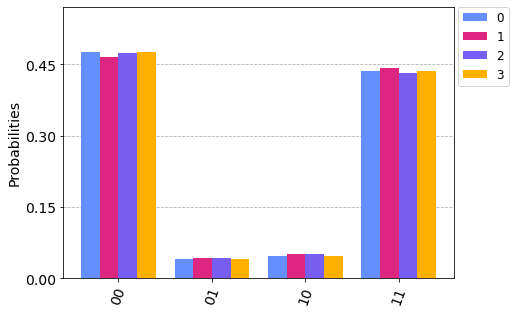

In [23]:
#for x in range(len(qcs_H)):
#    plt = visualize_counts(results_qasm_errors_H.get_counts(x)).show()
plot_histogram(results_qasm_errors_H.get_counts(), 
               legend=[str(x) for x in range(len(qcs_H))],
               bar_labels=False)

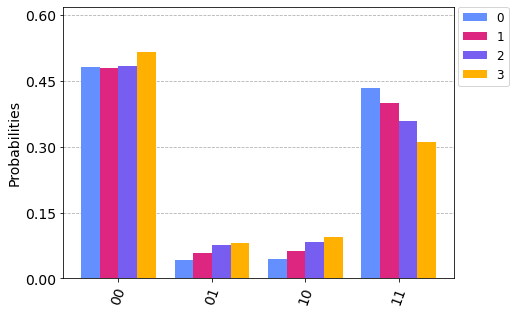

In [24]:
#for x in range(len(qcs_CNOT)):
#    plt = visualize_counts(results_qasm_errors_CNOT.get_counts(x)).show()
plot_histogram(results_qasm_errors_CNOT.get_counts(), 
               legend=[str(x) for x in range(len(qcs_CNOT))],
               bar_labels=False)

<hr>

# Error mitigation

In [25]:
# construct a set of calibration circuits to benchmark the readout process
calibration_circuts, calibration_labels = complete_meas_cal([0,1], qr, cr, circlabel='meas_cal')

In [26]:
calibration_circuts[3].draw()

┌───┐ ░ ┌─┐   
q_0: ┤ X ├─░─┤M├───
     ├───┤ ░ └╥┘┌─┐
q_1: ┤ X ├─░──╫─┤M├
     └───┘ ░  ║ └╥┘
c: 2/═════════╩══╩═
              0  1

In [27]:
# simulate the circuits with a realistic noise model
result_calibration = execute(calibration_circuts, Aer.get_backend('qasm_simulator'), shots=8192, 
                             backend_properties=backend.properties(),
                             noise_model=noise_model)

[[0.95 0.05 0.06 0.  ]
 [0.01 0.91 0.   0.06]
 [0.03 0.   0.92 0.05]
 [0.   0.03 0.01 0.89]]


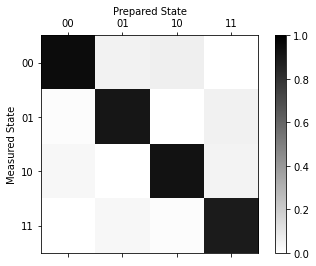

In [28]:
# analyze the results
measurement_fitter = CompleteMeasFitter(result_calibration.result(), calibration_labels, circlabel='meas_cal')
print (np.around(measurement_fitter.cal_matrix,2))
measurement_fitter.plot_calibration()

In [29]:
# apply the correction procedure to the results
results_qasm_errors_H_mitigated = measurement_fitter.filter.apply(results_qasm_errors_H)
results_qasm_errors_CNOT_mitigated = measurement_fitter.filter.apply(results_qasm_errors_CNOT)

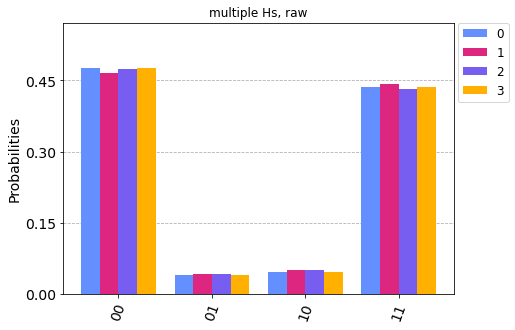

In [30]:
plot_histogram(results_qasm_errors_H.get_counts(),
               legend=[str(x) for x in range(len(qcs_H))],
               bar_labels=False,
               title='multiple Hs, raw')

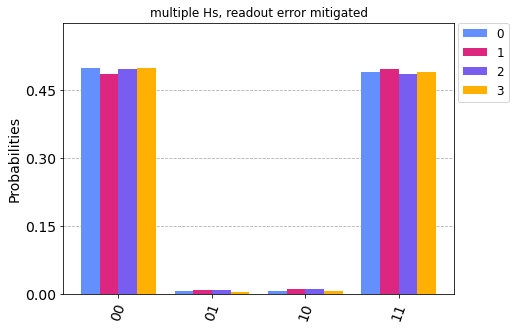

In [31]:
plot_histogram(results_qasm_errors_H_mitigated.get_counts(), 
               legend=[str(x) for x in range(len(qcs_H))],
               bar_labels=False,
               title='multiple Hs, readout error mitigated')

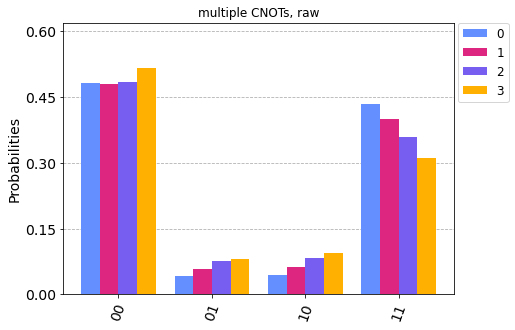

In [32]:
plot_histogram(results_qasm_errors_CNOT.get_counts(), 
               legend=[str(x) for x in range(len(qcs_CNOT))],
               bar_labels=False, 
               title='multiple CNOTs, raw')

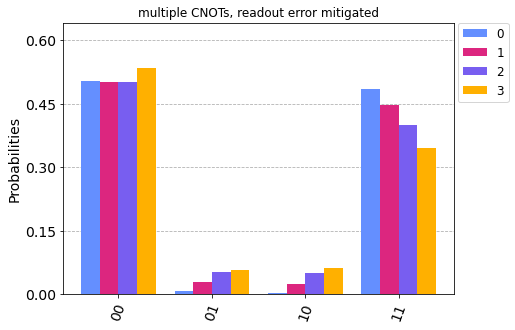

In [33]:
plot_histogram(results_qasm_errors_CNOT_mitigated.get_counts(), 
               legend=[str(x) for x in range(len(qcs_CNOT))],
               bar_labels=False,
               title='multiple CNOTs, readout error mitigated')

<hr>

# State tomography

In [35]:
qc_0 = prepare_Bell_state_gate_error_analysis(0, qr, None, 0, 0)
qc_N = prepare_Bell_state_gate_error_analysis(0, qr, None, 0, 60)

tomo_circuits_0 = state_tomography_circuits(qc_0, [qr[0], qr[1]])
tomo_circuits_N = state_tomography_circuits(qc_N, [qr[0], qr[1]])

In [36]:
tomo_circuits_0[1].draw()

░ ┌───┐      ░  ┌───┐ ┌─┐        
 q_0: ─░─┤ H ├──■───░──┤ H ├─┤M├────────
       ░ └───┘┌─┴─┐ ░ ┌┴───┴┐└╥┘┌───┐┌─┐
 q_1: ─░──────┤ X ├─░─┤ SDG ├─╫─┤ H ├┤M├
       ░      └───┘ ░ └─────┘ ║ └───┘└╥┘
c1: 2/════════════════════════╩═══════╩═
                              0       1

In [37]:
job_tomo_0 = execute(tomo_circuits_0, Aer.get_backend('qasm_simulator'), shots=8192,
                     backend_properties=backend.properties(), 
                     noise_model=noise_model)
job_tomo_N = execute(tomo_circuits_N, Aer.get_backend('qasm_simulator'), shots=8192,
                     backend_properties=backend.properties(), 
                     noise_model=noise_model)

job_tomo_0_mitigated = measurement_fitter.filter.apply(job_tomo_0.result())
job_tomo_N_mitigated = measurement_fitter.filter.apply(job_tomo_N.result())

stf_0 = StateTomographyFitter(job_tomo_0_mitigated, tomo_circuits_0)
tomo_data_0 = stf_0.fit()
stf_N = StateTomographyFitter(job_tomo_N_mitigated, tomo_circuits_N)
tomo_data_N = stf_N.fit()

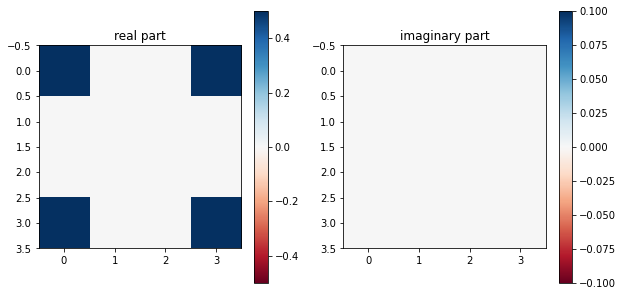

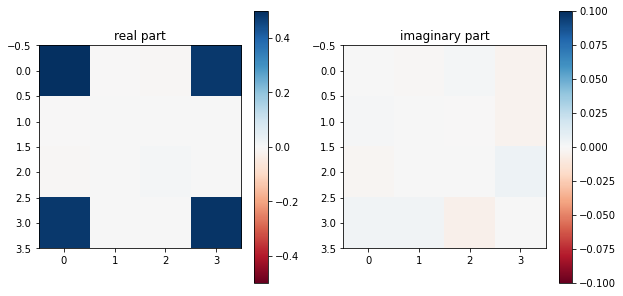

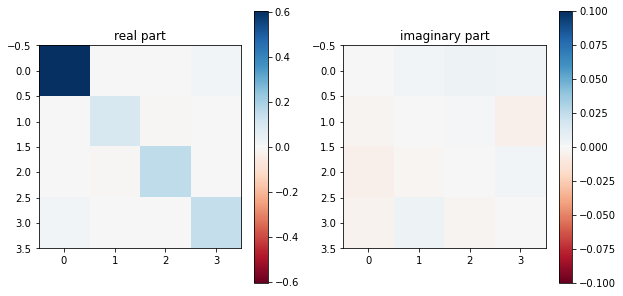

In [40]:
visualize_two_qubit_tomography(statevector_to_density_matrix(results_statevector.get_statevector(0)), 
                               clim_real=None, clim_imag=0.1)
visualize_two_qubit_tomography(tomo_data_0, clim_imag=0.1)
visualize_two_qubit_tomography(tomo_data_N, clim_imag=0.1)

<hr>